In [9]:
!pip install tdmclient numpy scipy opencv-python tqdm


In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

In [3]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock() 

CancelledError: 

In [2]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale
    
#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 10
B2_O = 80
B3_O = 80
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 5
B2_C = 10
B3_C = 10
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 10
B3_T = 10
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
Min_area_env = 1920*1080*0.4   #Min area in pixel of the env
Env_approx = 0.01

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.8   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.2
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False
#========================================================

In [3]:
if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(0)
    
if not cap.isOpened():
    print("Could not access webcam")






ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND


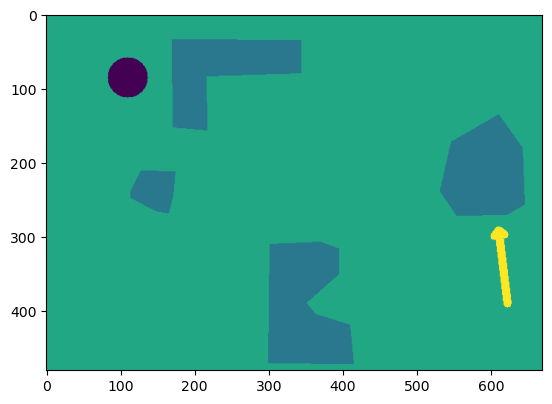

In [18]:
#INITIALIZATION
#GET A FRAME
img = com.get_picture_optimized(cap)
#img = cv2.imread("02.png")
#COMPUTE TRANSFORMATION MATRIX
matrix = com.matrix_perspective(img)
#CORRECT IMAGE
transformed_image = com.convert_perspective(img,matrix)

#PLOTTING
if DEBUG: 
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected Image")
    plt.axis('off')
    plt.show()


#GET GLOBAL MAP
global_map = com.get_map(transformed_image)

#GET ROBOT POSITION AND ORIENTATION
robot = com.get_robot(transformed_image)


length = 100
end_x = int(robot[0][0] + length * np.cos(robot[1]))
end_y = int(robot[0][1] + length * np.sin(robot[1]))
end_point = (end_x, end_y)
global_map4plot = global_map.copy()
cv2.arrowedLine(global_map4plot, [int(robot[0][0]), int(robot[0][1])], end_point, color=(2, 2, 2), thickness=10)
plt.imshow(global_map4plot)
plt.show()
if DEBUG : 
    global_map4plot = global_map.copy()
    cv2.arrowedLine(global_map4plot, robot[0], end_point, color=(2, 2, 2), thickness=10)
    plt.imshow(global_map4plot)
    plt.axis('off')
    plt.show()


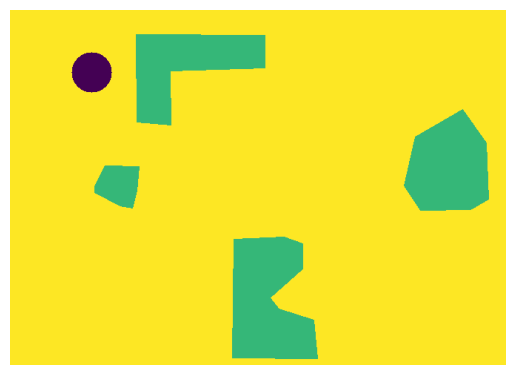

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[-3 -1  0]


In [19]:
#global_map[global_map == 1.] = -1.
global_map = global_map.astype(int)
from matplotlib import pyplot as plt
plt.imshow(global_map)
plt.axis('off')
plt.show()
print(global_map)
print(np.unique(global_map))

In [20]:
print(robot[0][1])

390.4940509915014


In [21]:
robot[0][0]

np.float64(623.5501416430595)

In [22]:
print(len(global_map[0]))

670


In [23]:
print(len(global_map))


480


In [24]:
int(round(robot[0][1]))

390

In [25]:
int(round(robot[0][0]))

624

In [26]:
solved = global_map[:]

path = path = gb.a_star(global_map, robot[1], 0.5, 
                 (int(round(robot[0][1])), int(round(robot[0][0]))))


480
670
390
624
308938


In [27]:
## HERE : make infinite loop that launches Filtering, motion and local avoidance
#empty = np.zeros((SIZE[0], SIZE[1]))
for i in path : 
    global_map[i[0]][i[1]] = -4 # marker for path in my debug functions

gb.debug_maze_to_bitmap(global_map, 20, filename="Global_Nav/tests/maze.png")